<font color='green'>
Predicción del valor de un índice bursátil (en este caso, el IBEX 35)
</font>

Los datos para construir el dataset se han obtenido de las siguientes páginas web:  
https://www.ine.es/  
https://datosmacro.expansion.com/deficit/espana  
https://es.finance.yahoo.com/quote/%5EIBEX/history?p=%5EIBEX  
https://es.investing.com/indices/spain-35-historical-data  

Los valores que se publican con carácter trimestral, se han ajustado para obtener valores mensuales. Cada parámetro se ha ajustado de una manera distinta, atendiendo a las características particulares de cada uno de ellos.

In [ ]:
!pip install tensorflow

In [15]:
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
import seaborn as sb

import random

In [16]:
#Carga de los datos

data = pd.read_csv('datosibex.csv', parse_dates=[0], index_col = 0, delimiter = ';')


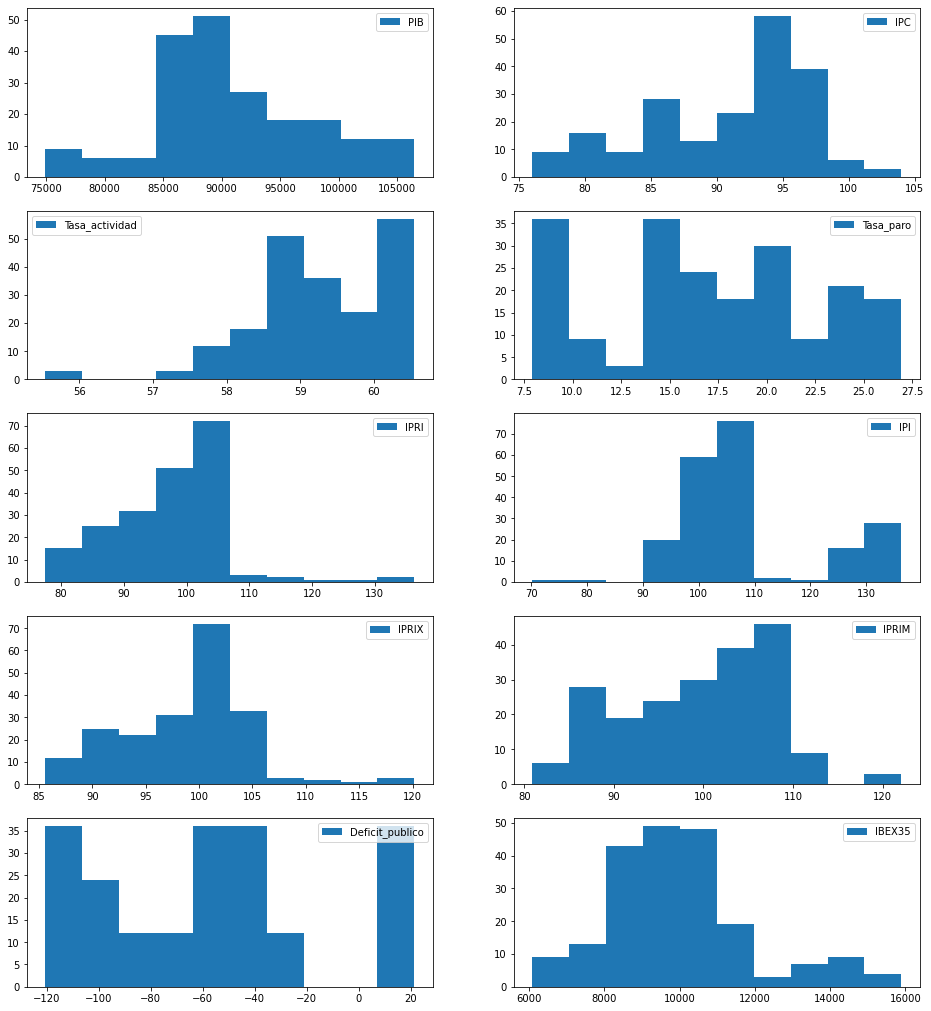

In [17]:
#Histogramas de las variables para ver su distribución

fg = plt.figure(figsize=(16, 18))
for pos in range(len(data.columns)) :
    fg.add_subplot(5, 2, pos+1)
    plt.hist(data[data.columns[pos]], label = [data.columns[pos]])
    plt.legend()
plt.show()

In [18]:
#Limpieza del dataframe

#Detección de celdas vacías
data.replace(['', np.inf], np.nan)
print('Número de filas con algún valor nulo:', len(data.loc[data.isna().any(axis=1)]))
print()
#Detección de datos en formato incorrecto
for columna in data.columns :
    print(f'Tipo de dato de la variable {columna}:', data[columna].dtypes)
print()
#Detección de datos erróneos
print('Descripción numérica de los datos cargados:')
print(data.describe())
print()
#Detección de duplicados
print('Filas duplicadas:', data.loc[data.duplicated()])

Número de filas con algún valor nulo: 0

Tipo de dato de la variable PIB: int64
Tipo de dato de la variable IPC: float64
Tipo de dato de la variable Tasa_actividad: float64
Tipo de dato de la variable Tasa_paro: float64
Tipo de dato de la variable IPRI: float64
Tipo de dato de la variable IPI: float64
Tipo de dato de la variable IPRIX: float64
Tipo de dato de la variable IPRIM: float64
Tipo de dato de la variable Deficit_publico: float64
Tipo de dato de la variable IBEX35: float64

Descripción numérica de los datos cargados:
                 PIB         IPC  Tasa_actividad   Tasa_paro        IPRI  \
count     204.000000  204.000000      204.000000  204.000000  204.000000   
mean    90860.720588   90.930098       59.261471   17.065000   97.280343   
std      6901.102672    6.172816        0.943676    5.615648    9.196999   
min     74938.000000   76.050000       55.540000    7.930000   77.500000   
25%     86079.500000   86.535000       58.727500   13.787500   90.525000   
50%     89394

Diagramas de caja para comprobar si hay outliers:


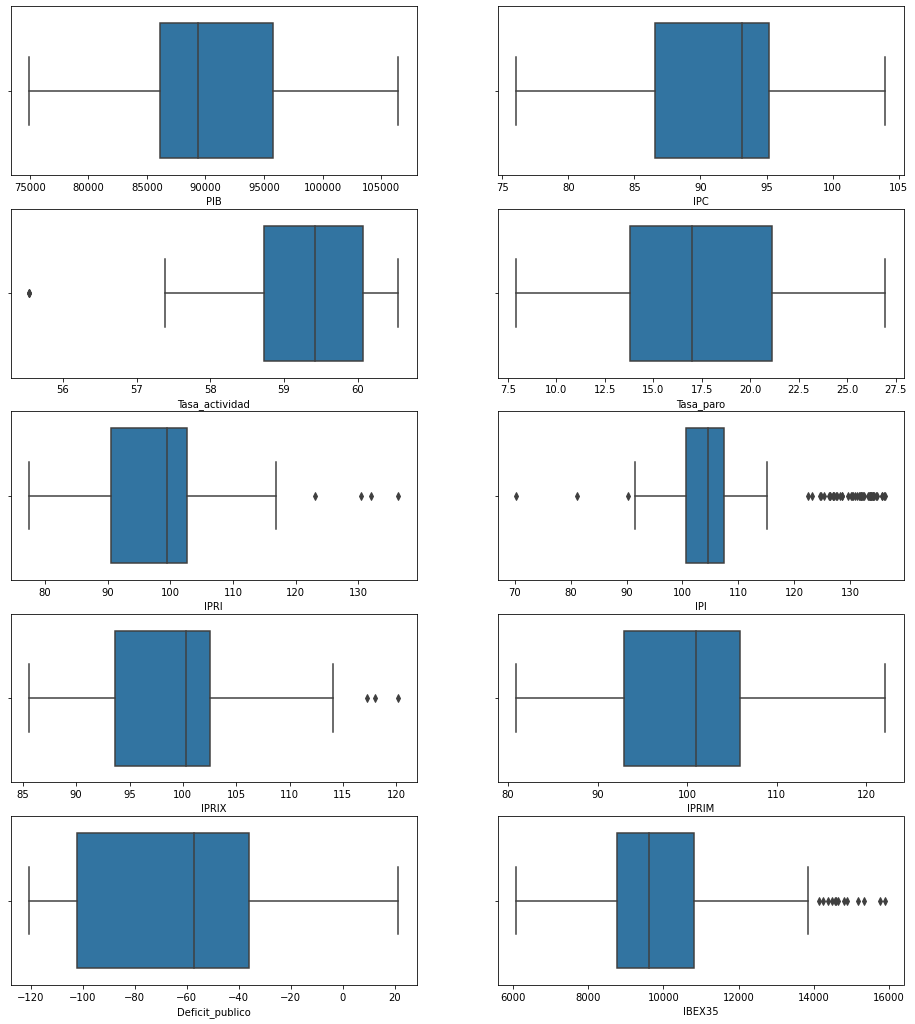

In [19]:
#Detección de outliers
print('Diagramas de caja para comprobar si hay outliers:')
fg = plt.figure(figsize=(16, 18))
for pos in range(len(data.columns)) :
    fg.add_subplot(5, 2, pos+1)
    sb.boxplot(x=data[data.columns[pos]], orient = "h", labels=[data.columns[pos]])
plt.show()

Vamos a eliminar los outliers que se observan en los parámetros Tasa_actividad, IPRI, IPI, IPRIX e IBEX35.

In [20]:
#Eliminamos los outliers por el método del rango intercuartil

descripcion = data.describe()
outliers = pd.DataFrame()
for columna in ['Tasa_actividad', 'IPRI', 'IPI', 'IPRIX', 'IBEX35'] :
    q25 = descripcion.loc['25%'][columna]
    q75 = descripcion.loc['75%'][columna]

    lim_inferior = q25 - 1.5*(q75 - q25)
    lim_superior = q75 + 1.5*(q75 - q25)

    outliers_aux = data.query(f"{columna} < @lim_inferior or {columna} > @lim_superior")
    outliers = pd.concat([outliers, outliers_aux], axis=0)

outliers.drop_duplicates(inplace = True)

inliers = data.drop(list(outliers.index), axis = 0)

print('Dimensión de outliers:', outliers.shape)
print('Dimensión de inliers:', inliers.shape)

data = inliers.copy()

Dimensión de outliers: (52, 10)
Dimensión de inliers: (152, 10)


<font color='green'>
--- APLICAMOS REDES NEURONALES ---
</font>

In [21]:
# Dividimos las muestras en dos conjuntos: uno para entrenamiento y otro para testeo
data_train = data.sample(frac=0.7, random_state=0)
data_valid = data.drop(data_train.index)

#Escalamos dentro del rango [0, 1]
max_ = data_train.max(axis=0)
min_ = data_train.min(axis=0)
data_train = (data_train - min_) / (max_ - min_)
data_valid = (data_valid - min_) / (max_ - min_)

#Separamos data_train y data_valid en X (características, variables independientes) e y (objetivo, variable dependiente)
X_train = data_train.drop('IBEX35', axis=1)
X_valid = data_valid.drop('IBEX35', axis=1)
y_train = data_train['IBEX35']
y_valid = data_valid['IBEX35']


In [22]:
print(X_train.shape)
print(X_valid.shape)

(106, 9)
(46, 9)


In [23]:
#MODELO

#Creamos cuatro capas:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[9]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1)
])

#Definimos el optimizador y la función de pérdida
model.compile(
    optimizer='adam',   # gradiente descendiente estocástico
    loss='mae',   #error absoluto medio
    metrics = [keras.metrics.MeanSquaredError()]
)

#Entrenamos el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=40,
    epochs=38
)

Epoch 1/38
3/3 [==============================] - 1s 121ms/step - loss: 0.4014 - mean_squared_error: 0.2152 - val_loss: 0.2280 - val_mean_squared_error: 0.0727
Epoch 2/38
3/3 [==============================] - 0s 27ms/step - loss: 0.2053 - mean_squared_error: 0.0663 - val_loss: 0.2325 - val_mean_squared_error: 0.0847
Epoch 3/38
3/3 [==============================] - 0s 27ms/step - loss: 0.1922 - mean_squared_error: 0.0540 - val_loss: 0.1769 - val_mean_squared_error: 0.0450
Epoch 4/38
3/3 [==============================] - 0s 26ms/step - loss: 0.1510 - mean_squared_error: 0.0349 - val_loss: 0.1742 - val_mean_squared_error: 0.0471
Epoch 5/38
3/3 [==============================] - 0s 27ms/step - loss: 0.1370 - mean_squared_error: 0.0291 - val_loss: 0.1575 - val_mean_squared_error: 0.0370
Epoch 6/38
3/3 [==============================] - 0s 25ms/step - loss: 0.1399 - mean_squared_error: 0.0294 - val_loss: 0.1445 - val_mean_squared_error: 0.0331
Epoch 7/38
3/3 [=============================

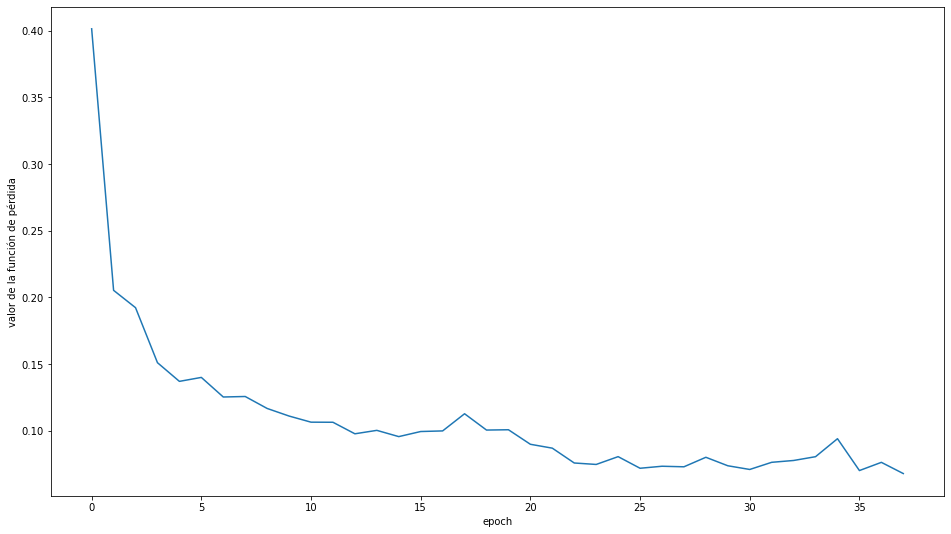

In [24]:
#Llevamos los datos de la variable "history" a un dataframe para ver cómo responde la función de pérdida 
#a las iteraciones

history_df = pd.DataFrame(history.history)

#Generamos una gráfica con esos datos
history_df['loss'].plot()
plt.xlabel('epoch')
plt.ylabel('valor de la función de pérdida')
plt.show()

In [25]:
#Realizamos la predicción

results=model.predict(X_valid)

2/2 [==============================] - 0s 3ms/step


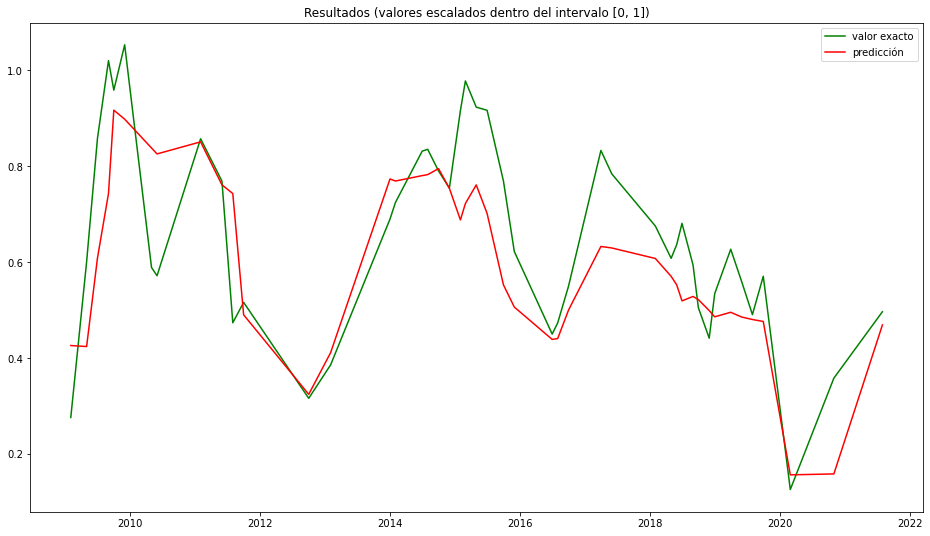

In [26]:
#Creamos una gráfica con los resultados (valores todavía escalados en el rango [0, 1])

X = np.array(X_valid.index, dtype='datetime64[M]')

plt.figure()
plt.plot(X, y_valid, c='g', label = 'valor exacto')
plt.plot(X, results,c='r', label = 'predicción')
plt.title('Resultados (valores escalados dentro del intervalo [0, 1])')
plt.legend()
plt.show()

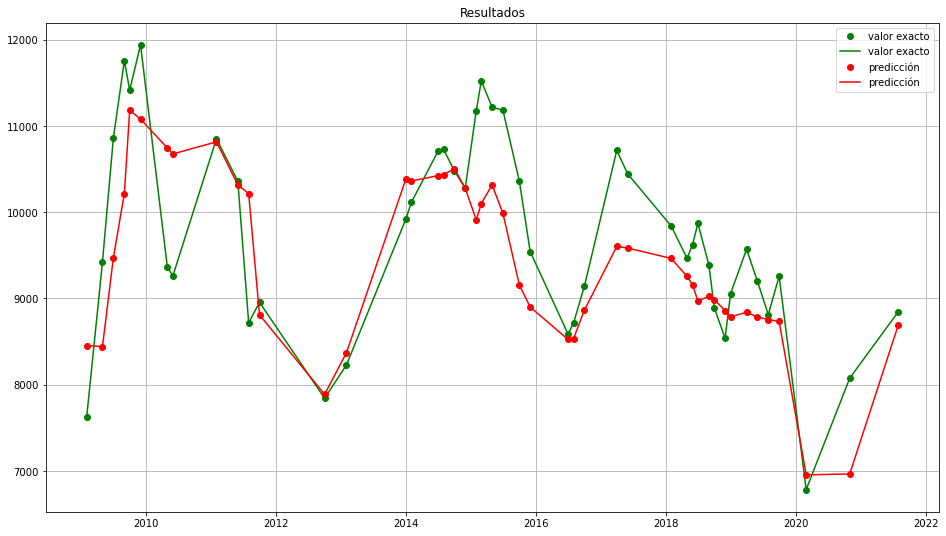

In [27]:
#Recuperamos los valores reales del IBEX35 desescalando los resultados

#(max_ y min_ eran las variables que habíamos usado para escalar los valores al principio del programa)

results_f = results*(max_.loc['IBEX35'] - min_.loc['IBEX35']) + min_.loc['IBEX35']
y_valid_f = y_valid*(max_.loc['IBEX35'] - min_.loc['IBEX35']) + min_.loc['IBEX35']

#creamos la gráfica con los resultados finales
plt.figure()
plt.plot(X, y_valid_f, 'go',  X, y_valid_f, 'g-', label = 'valor exacto')
plt.plot(X, results_f,'ro', X, results_f,'r-', label = 'predicción')
plt.title('Resultados')
plt.legend()
plt.grid()
plt.show()

In [28]:
#Calculamos el porcentaje de error de los resultados de la predicción

r_exactos = y_valid_f.to_numpy()   #resultados exactos
r_predic = results_f[:, 0]   #resultados de la predicción

error = (r_exactos - r_predic) / r_exactos
error = np.absolute(error)
print('Número de valores con un error mayor al 25%:', np.where(error >= 0.25)[0].size)

media_error = np.mean(error, axis=0)
print('\nEl error medio es (en %):', media_error*100)
print('La precisión media es (en %):', 100-(media_error*100))

Número de valores con un error mayor al 25%: 0

El error medio es (en %): 5.965245778808108
La precisión media es (en %): 94.03475422119189
